## imports

In [423]:
import collections
import glob
import json
import os
import uuid

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import pandas as pd
from scipy import ndimage

## utilities

### I/O

#### logs

In [406]:
def read_events(fname):
    success_statuses = ['KSP_CONVERGED_RTOL', 'SCIPY_SUCCESS', 'AZ_normal', 
                        'KSP_CONVERGED_ITS', 'KSP_CONVERGED_RTOL', 
                        'Pysparse_CONVERGED_RTOL', 'AMGX_SOLVE_SUCCESS']
    events = []
    state = {}
    versions = {}

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        simulation_id = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("DEBUG", "fipy", "<module>"):
                versions = json.loads(msg)
                # # fix name collision
                # versions["package"]["solver_suite"] = versions["package"]["solver"]
                # del versions["package"]["solver"]
            elif (level, logger, function) == ("INFO", "fipy", "<module>"):
                # obsolete log format
                versions = {"package": json.loads(msg)}
            elif (level, function) == ("DEBUG", "<module>"):
                if msg.startswith("result stored in"):
                    continue
                state = json.loads(msg)
                state["logfile"] = fname
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state["solve_time"] = str(solve_time)
                if state["state"] == "START":
                    # create unique id for each simulation run
                    simulation_id = uuid.uuid4()
                    converged = False
                state["simulation_id"] = simulation_id
                state["converged"] = converged
                state.update(versions)
                events.append(state.copy())
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state.copy())
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                converged = event["status_name"] in success_statuses
                events.append(event)
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df["solve_time"] = pd.to_timedelta(df["solve_time"])    
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[df2["state"] == "END"].sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

#### data files

In [772]:
def read_tsv(tsv):
    x, y, v = np.loadtxt(tsv, skiprows=1, unpack=True)
    N = int(np.sqrt(len(x)))
    return [field.reshape((N,N)) for field in (x, y, v)] + [N]

def read_npz(npz):
    data = np.load(npz)
    return data["x"], data["y"], data["value"], data["value"].shape[0]

def tsv2npz(tsv):
    x, y, v, N = read_tsv(tsv)
    np.savez(os.path.splitext(tsv)[0], x=x, y=y, value=v)

In [774]:
def load_field(record, fname, key):
    """Load and intorpolate `path2` to resolution of `path1`
    
    Parameters
    ----------
    record : pd.Series
        Pandas Series with information about particular results to load.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `record`.
    key : str
        Designation of the field of interest

    Returns
    -------
    field : ndarray
        2D array of values.
    """
    preconditioner = record["preconditioner"]
    if preconditioner == "unpreconditioned":
        preconditioner = "NoneType"

    path = os.path.join(os.path.dirname(record["logfile"]),
                        record["package.solver"], record["solver_class"],
                        preconditioner, str(record["numberOfElements"]),
                        fname)

    try:
        with np.load(path) as data:
            field = data[key]
    except:
        field = None

    return field

### plot scaling

In [444]:
def plot_all(df, color_by_suite=True,
             by=["package.solver", "solver_class", "preconditioner"]):
    color_map = {
        'no-pysparse': 'red',
        'trilinos': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    groups = df.groupby(by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "all"),
                        count=("elapsed_seconds", "count"),
                        mean=("elapsed_seconds", "mean"),
                        std=("elapsed_seconds", "std")).reset_index()
    groups = groups.groupby(by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1.5)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, marker=".", markersize=1.5)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
        # plot uncertainty
        err = group["std"] / np.sqrt(group["count"])
        ax.fill_between(group["numberOfElements"],
                        group["mean"] - err,
                        group["mean"] + err,
                        color=color,
                        alpha=0.1)

    if color_by_suite:
        legend_elements = [Line2D([0], [0], color=c, label=s)
                           for s, c in color_map.items()
                           if s in df["package.solver"].unique()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1., 1.))
    else:
        # only label converged lines
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    if ~df["converged"].astype(bool).all():
        legend_elements = [Line2D([0], [0], color="black", marker=".", markersize=1.5),
                           Line2D([0], [0], color="black", linewidth=0, marker="x")]
        leg = Legend(ax, handles=legend_elements, labels=["converged", "not converged"],
                     loc='upper left', frameon=False)
        ax.add_artist(leg);

    ax.set_ylabel("elapsed time / s")
    ax.set_xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        plot_all(group1, by=["package.solver", "preconditioner"])
        plt.title(solver_class)
        
def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["package.solver", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

### plot solutions

In [775]:
def compare(coarse, fine):
    # "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
    x_coarse, y_coarse, v_coarse, N_coarse = read_tsv(coarse)
    x_fine, y_fine, v_fine, N_fine = read_tsv(fine)

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(131)  # coarse
    ax2 = fig.add_subplot(132)  # error
    ax3 = fig.add_subplot(133)  # fine
    resampled = ndimage.zoom(v_fine, N_coarse / N_fine)
    ax1.imshow(v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax2.imshow(resampled-v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax3.imshow(resampled, vmin=v_fine.min(), vmax=v_fine.max())

    ax2.set_title("{0}x{0}: L2(error) = {1}".format(N_coarse, np.sqrt(((resampled - v_coarse)**2)).sum() / N_coarse**2))

def scale_and_diff(v1, v2):
    """Interpolate and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at resolution of whichever is lower).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        diff = ndimage.zoom(v2, N1 / N2) - v1
    else:
        diff = v2 - ndimage.zoom(v1, N2 / N1)
    
    return diff

def extract_and_diff(v1, v2):
    """Slice and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at size of whichever is smaller).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        diff = v2[lower:upper, lower:upper] - v1
    else:
        lower, upper = int((N1 - N2) / 2), int((N1 + N2) / 2)
        diff = v2 - v1[lower:upper, lower:upper]
    
    return diff

def value1(v1, v2):
    """Slice and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at size of whichever is smaller).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v1
    elif N2 > N1:
        diff = v1
    else:
        lower, upper = int((N1 - N2) / 2), int((N1 + N2) / 2)
        diff = v1[lower:upper, lower:upper]
    
    return diff

def value2(v1, v2):
    """Slice and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at size of whichever is smaller).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2
    elif N2 > N1:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        diff = v2[lower:upper, lower:upper]
    else:
        diff = v2
    
    return diff

In [784]:
def perpendicular_label(ax, baseline, color, label, horizontal):
    kwargs = dict(text=label, size=8, color=color,
                  textcoords='offset points', xycoords='axes fraction')
    if horizontal:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=90,
                          ha='center', va='bottom', **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=0,
                          ha='right', va='center', **kwargs)
    return ann

def parallel_label(ax, baseline, color, label, horizontal):
    kwargs = dict(text=label, size=10, color=color,
                  textcoords='offset points', xycoords='axes fraction',
                  ha='center', va='center')
    if horizontal:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=0,
                          **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=90,
                          **kwargs)
    return ann
    
def label_multiindex(df, axs, horizontal=True, offset=0, baseline=0):
    if not isinstance(df, pd.DataFrame):
        return 0, 1, baseline
    elif isinstance(df.index, pd.MultiIndex):
        labels = df.index.levels[0]
        name = df.index.names[0]
    else:
        labels = df.index
        name = df.index.name

    count = 0
    label_width = 0
    next_baseline = baseline
    for label in labels:
        labeldf = df.loc[label]
        level, num, prev_baseline = label_multiindex(labeldf, axs,
                                                    horizontal=horizontal, offset=offset + count,
                                                    baseline=baseline)
        
        if name == "numberOfElements":
            label = '{0}x{0}'.format(int(np.sqrt(label)))

        try:
            # labeldf is a Series
            converged = bool(labeldf.all())
        except ValueError:
            # labeldf is a DataFrame
            converged = bool(labeldf.all().all())
        if converged:
            color = "black"
        else:
            color = "red"

        prev_baseline += 10
        ax = axs[offset + count + num // 2]
        if level == 0:
            ann = perpendicular_label(ax, prev_baseline, color, label, horizontal=horizontal)
        else:
            ann = parallel_label(ax, prev_baseline, color, label, horizontal=horizontal)

        renderer = ax.get_figure().canvas.get_renderer()
        bbox = ann.get_window_extent(renderer=renderer)
        if horizontal:
            next_baseline = max(next_baseline, prev_baseline + bbox.y1 - bbox.y0)
        else:
            next_baseline = max(next_baseline, prev_baseline + bbox.x1 - bbox.x0)
            
        count += num

    return level + 1, count, next_baseline

In [786]:
def plot_error_matrix(dfA, dfB, by, datafile, diff_fn=scale_and_diff, key="value", logvalue=True):
    groupsA = dfA.groupby(by)
    groupsB = dfB.groupby(by)
    
    fig, axs = plt.subplots(ncols=len(groupsA), nrows=len(groupsB),
                            figsize=(10, 10 * len(groupsB) / len(groupsA)))
    plt.setp(axs.flat, xticks=[], yticks=[], frame_on=False)

    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')

    for col, (keyA, groupA) in zip(axs.T, groupsA):
        for ax, (keyB, groupB) in zip(col, groupsB):
            fieldA = load_field(record=groupA.iloc[0], fname=datafile, key=key)
            fieldB = load_field(record=groupB.iloc[0], fname=datafile, key=key)
            diff = diff_fn(fieldA, fieldB)
            
            if diff is not None:
                if groupA["converged"].all() & groupB["converged"].all():
                    cmap = converged_cmap
                else:
                    cmap = diverged_cmap
                if logvalue:
                    ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)
                else:
                    ax.imshow(diff, cmap=cmap)

    convergedA = groupsA.agg({"converged": "all"})
    label_multiindex(convergedA, axs[0], horizontal=True)
    
    convergedB = groupsB.agg({"converged": "all"})
    label_multiindex(convergedB, axs[:, 0], horizontal=False)

## diffusion

### macOS

In [370]:
events = read_events("macOS/macos.log")

macos = events2df(events)
macos_total = extract_total_times(macos)

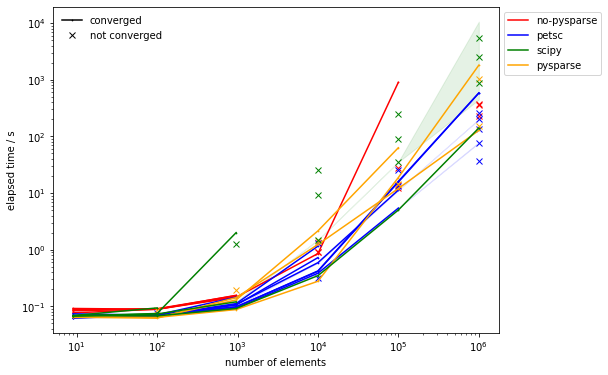

In [373]:
plot_all(macos_total)

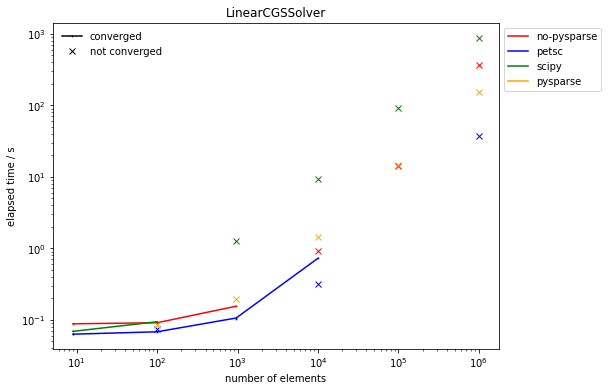

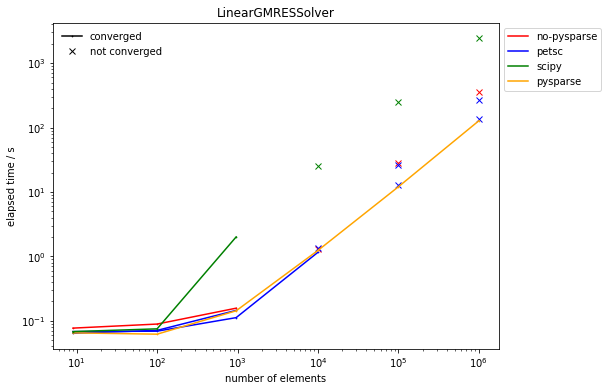

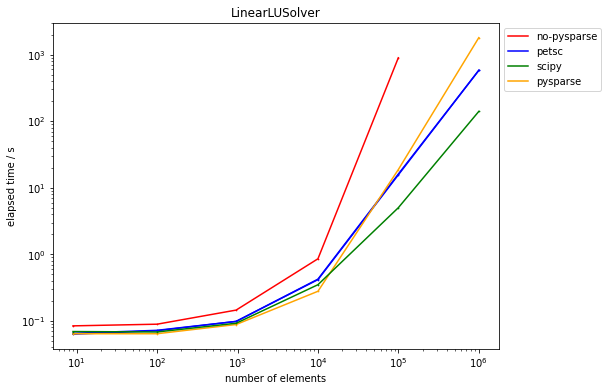

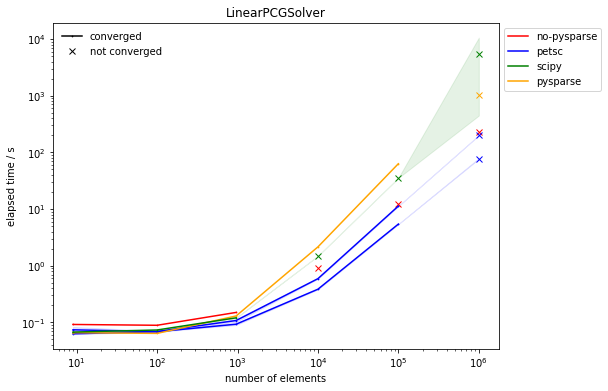

In [374]:
plot_by_solver(macos_total)

In [375]:
macos_sweep = extract_sweep_times(macos)

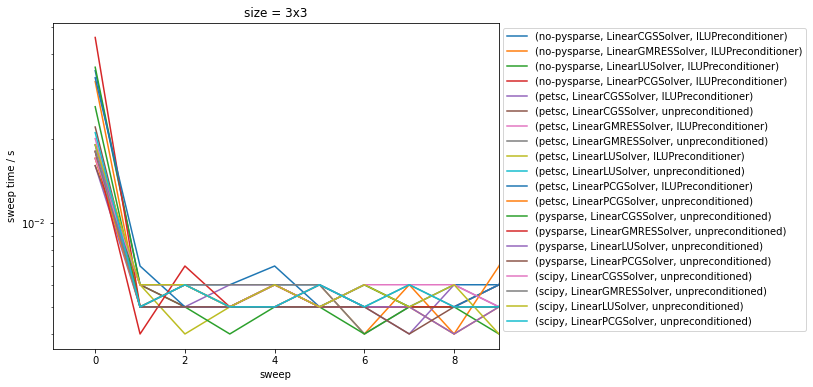

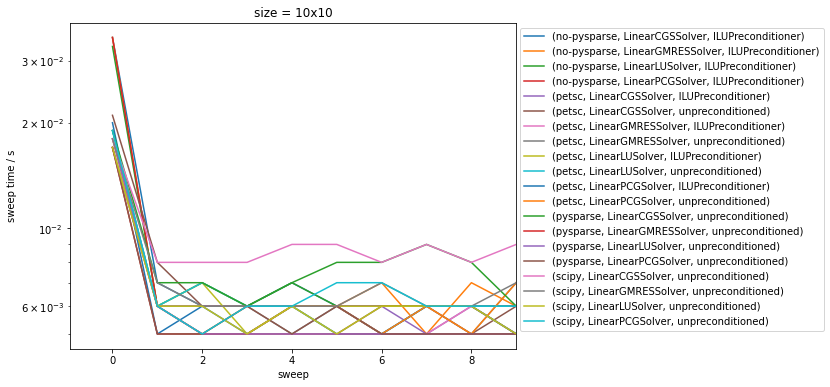

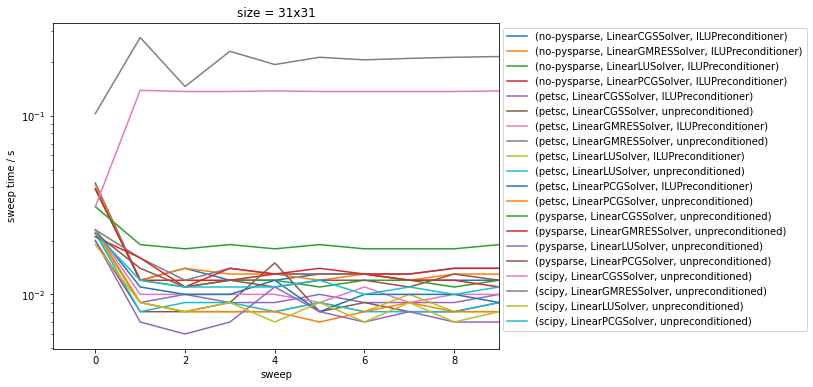

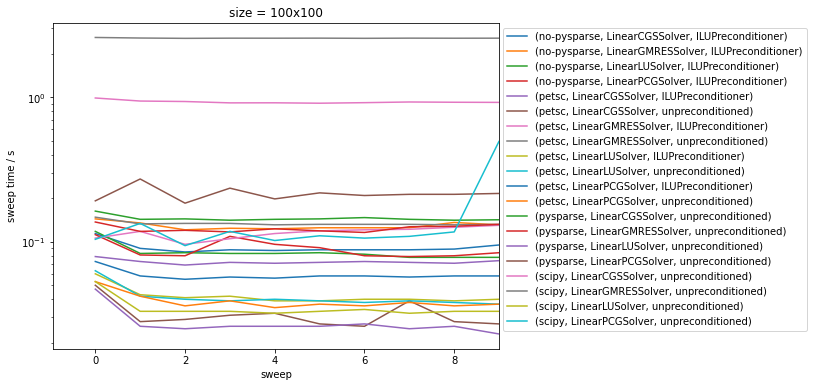

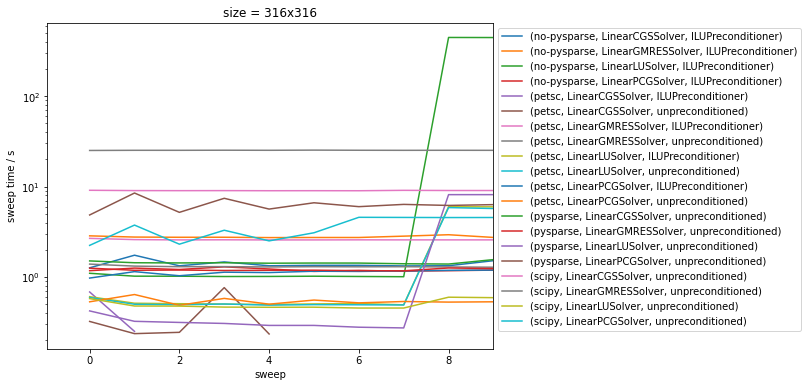

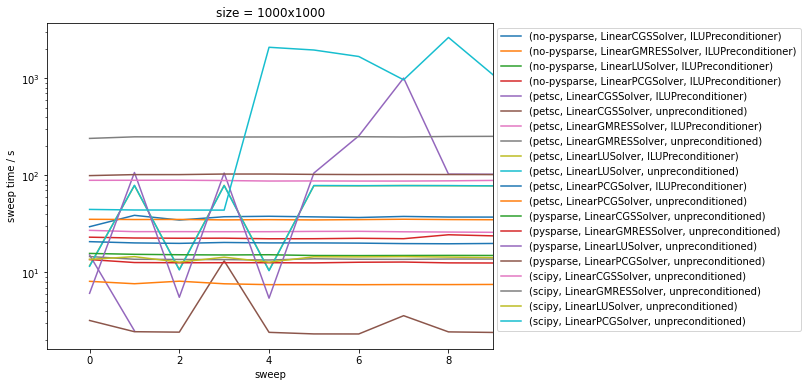

In [376]:
plot_sweep_times(macos_sweep)

### GPUs

In [377]:
gpu = events2df(read_events("gpu/gpu.log"))
gpu_total = extract_total_times(gpu)

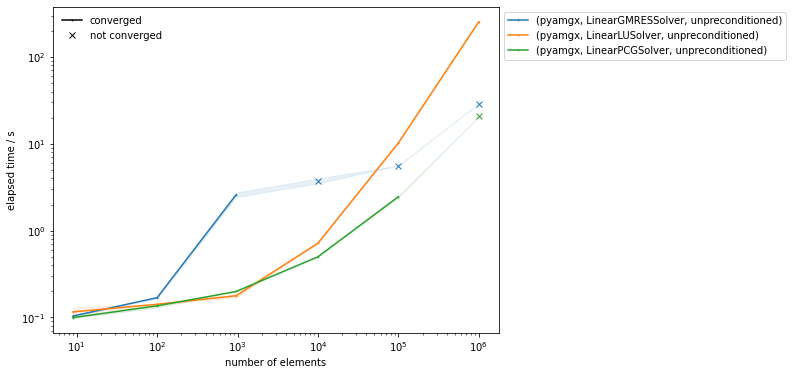

In [379]:
plot_all(gpu_total, color_by_suite=False)

In [380]:
gpu_sweep = extract_sweep_times(gpu)

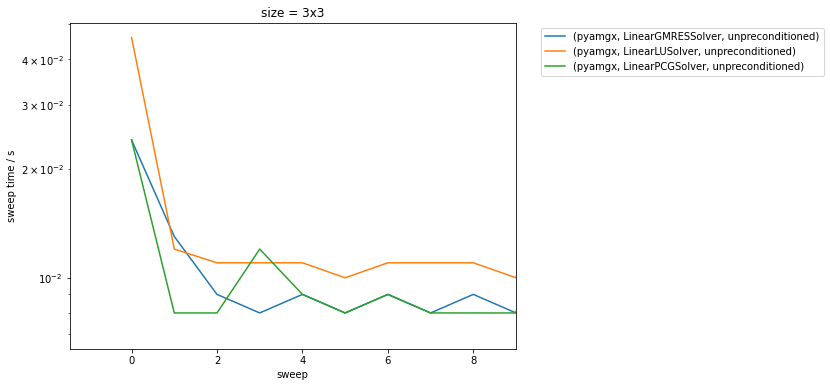

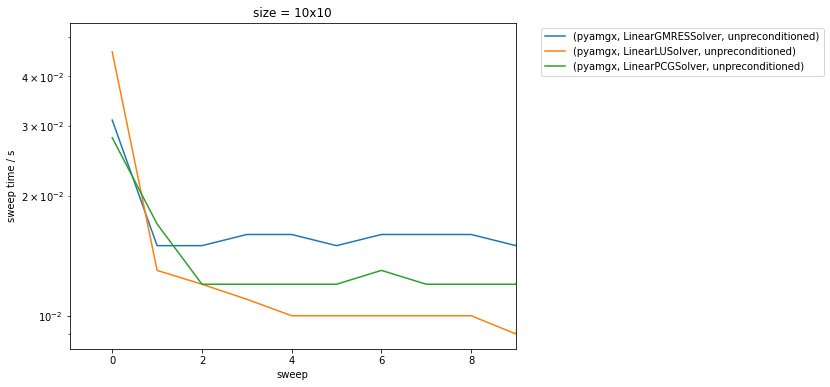

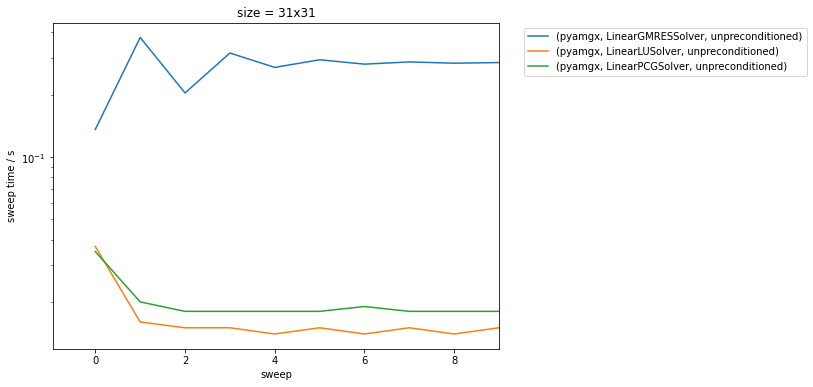

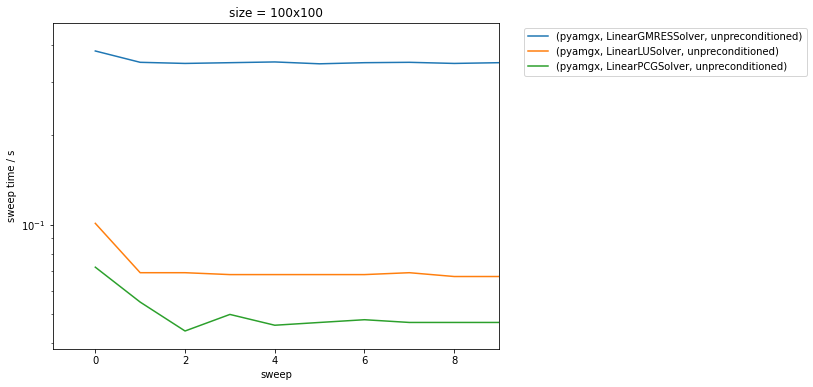

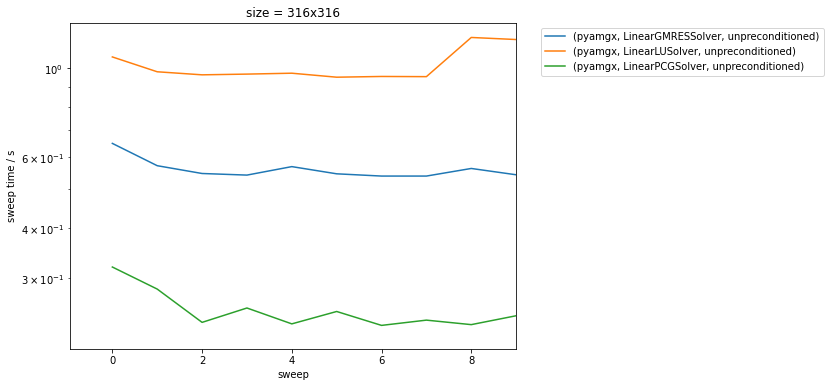

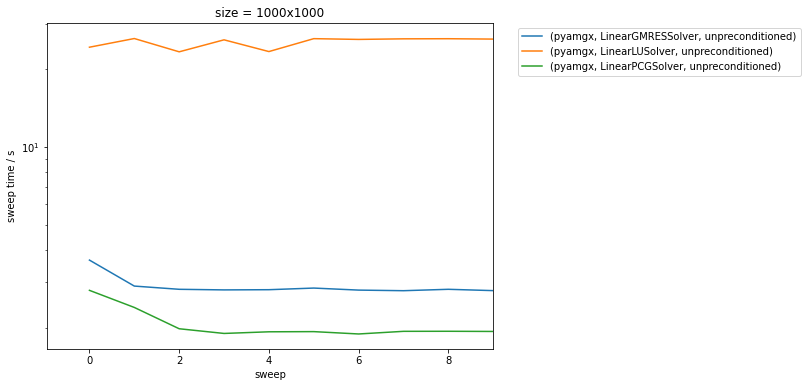

In [381]:
plot_sweep_times(gpu_sweep)

### Linux

In [764]:
events = []
for fname in glob.glob("linux/linux.*.log"):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

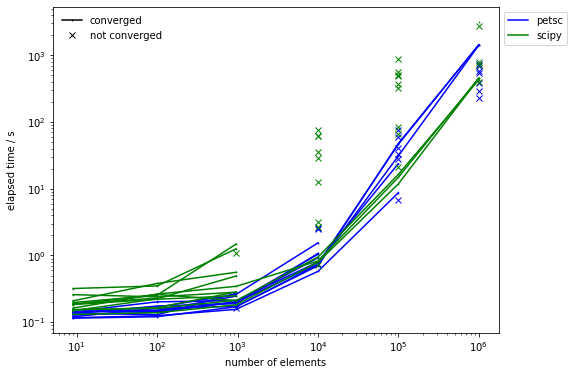

In [765]:
plot_all(linux_total)

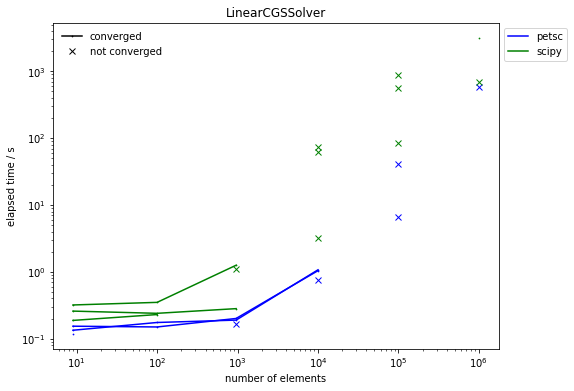

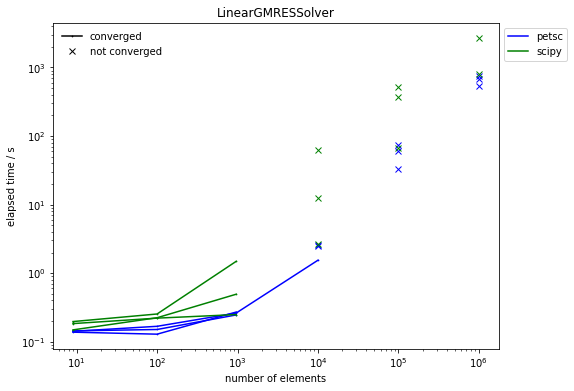

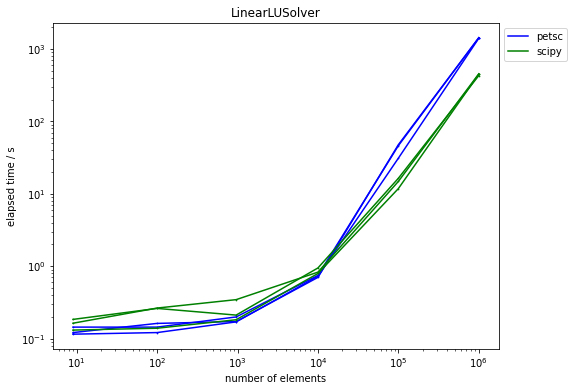

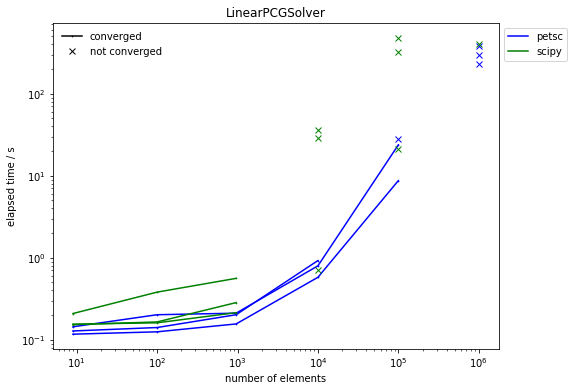

In [384]:
plot_by_solver(linux_total)

#### arithmetic

In [397]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/arithmetic_diffusion/solver.*.log"):
    events.extend(read_events(fname))

arithmetic = events2df(events)
arithmetic_total = extract_total_times(arithmetic)

(10.0, 1000000.0)

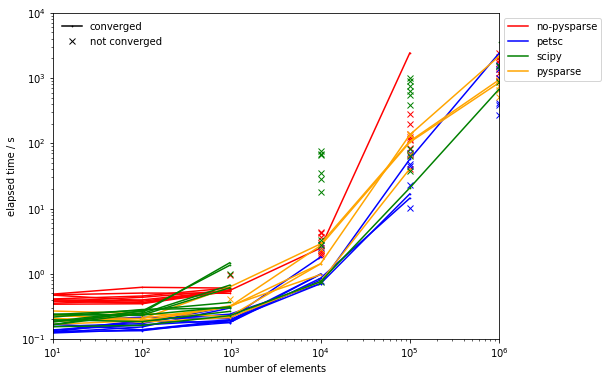

In [398]:
trilinos = arithmetic_total["package.solver"] == "no-pysparse"
petsc = arithmetic_total["package.solver"] == "petsc"
scipy = arithmetic_total["package.solver"] == "scipy"
pysparse = arithmetic_total["package.solver"] == "pysparse"

# plot_all(harmonic_total[pysparse | scipy])
plot_all(arithmetic_total)
plt.ylim(bottom=1e-1, top=1e4)
plt.xlim(left=1e1, right=1e6)

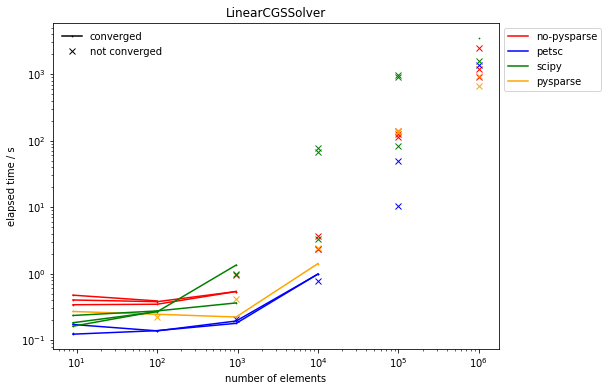

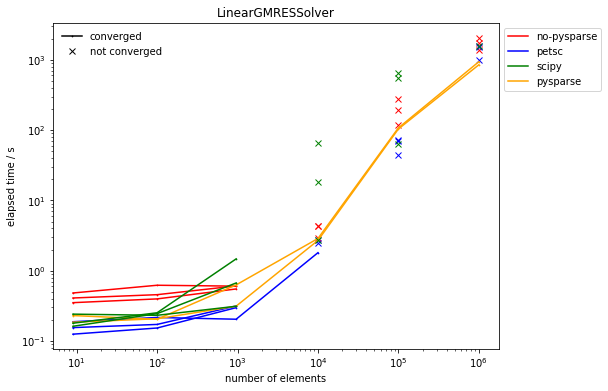

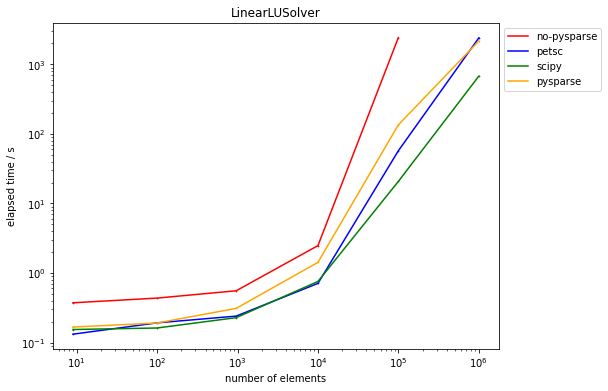

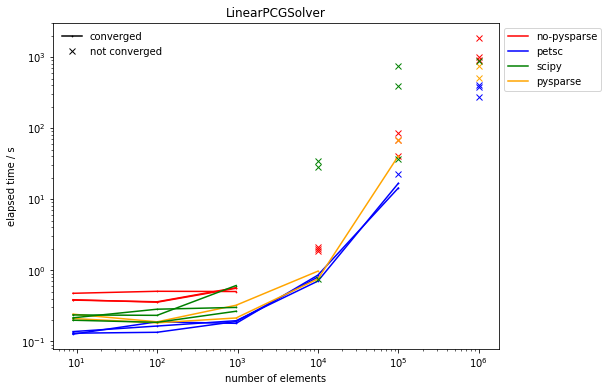

In [393]:
plot_by_solver(arithmetic_total)

In [394]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic_right/solver.*.log"):
    events.extend(read_events(fname))

harmonic_right = events2df(events)
harmonic_right_total = extract_total_times(harmonic_right)

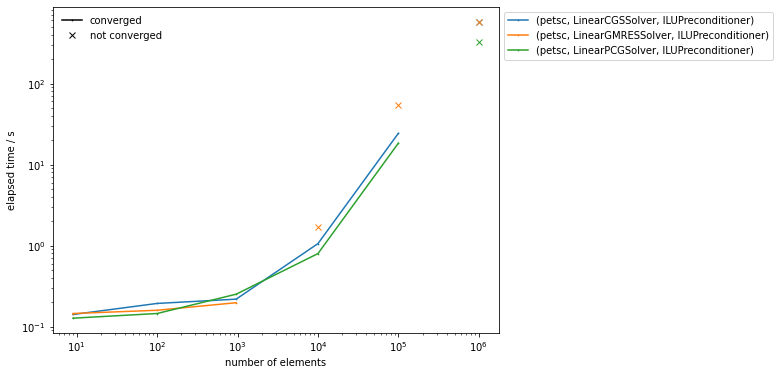

In [396]:
plot_all(harmonic_right_total, color_by_suite=False)

#### harmonic

In [400]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

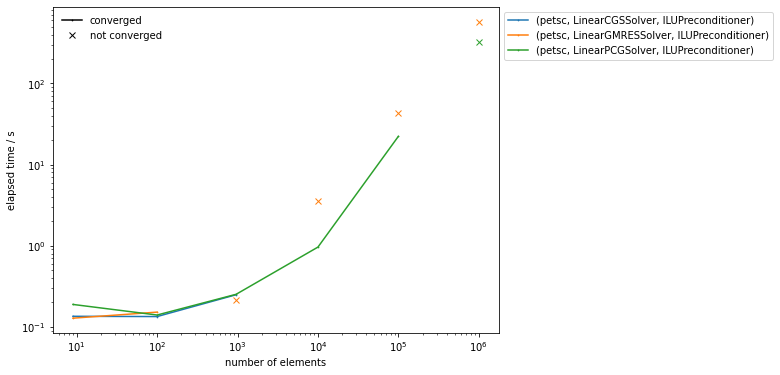

In [401]:
plot_all(harmonic_total, color_by_suite=False)

#### constant

In [385]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/constant_diffusion/solver.*.log"):
    events.extend(read_events(fname))

constant = events2df(events)
constant_total = extract_total_times(constant)

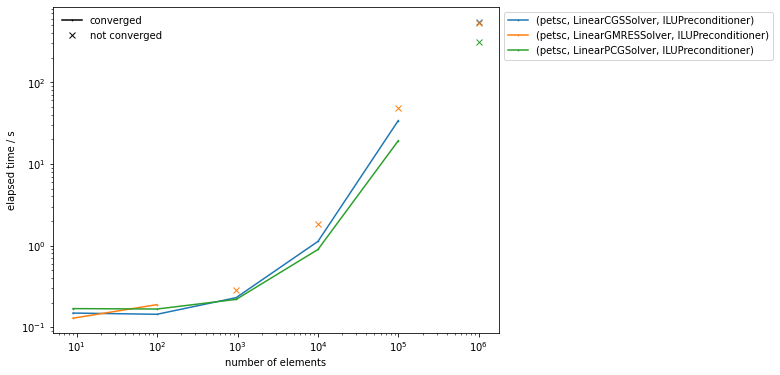

In [387]:
plot_all(constant_total, color_by_suite=False)

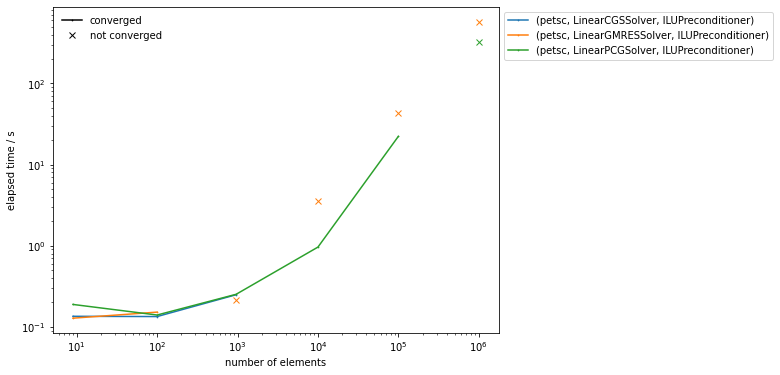

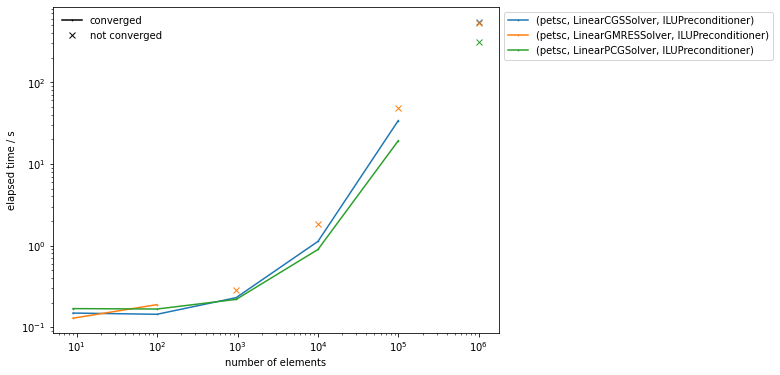

In [390]:
plot_all(harmonic_total, color_by_suite=False)
plot_all(constant_total, color_by_suite=False)

## nucleation

In [442]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/nucleation2[3,5]/solver.*.log"):
    events.extend(read_events(fname))

nucleation = events2df(events)
nucleation_total = extract_total_times(nucleation)

In [408]:
for col in nucleation_total.columns:
    print(col)

state
numberOfElements
sweeps
preconditioner
logfile
time_stamp
solver_class
solve_time
simulation_id
converged
argv
platform.architecture
platform.machine
platform.node
platform.platform
platform.processor
platform.release
platform.system
platform.version
package.python
package.fipy
package.numpy
package.pysparse
package.scipy
package.matplotlib
package.mpi4py
package.petsc4py
package.pyamgx
package.PyTrilinos
package.mayavi
package.gmsh
package.solver
conda.conda_info.GID
conda.conda_info.UID
conda.conda_info.active_prefix
conda.conda_info.active_prefix_name
conda.conda_info.av_data_dir
conda.conda_info.av_metadata_url_base
conda.conda_info.channels
conda.conda_info.conda_build_version
conda.conda_info.conda_env_version
conda.conda_info.conda_location
conda.conda_info.conda_prefix
conda.conda_info.conda_private
conda.conda_info.conda_shlvl
conda.conda_info.conda_version
conda.conda_info.config_files
conda.conda_info.default_prefix
conda.conda_info.env_vars.CDPATH
conda.conda_info.env

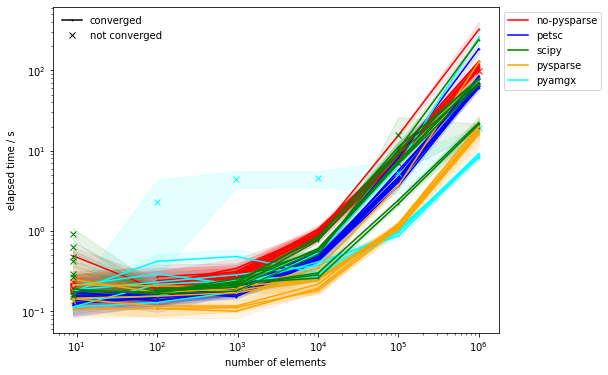

In [445]:
plot_all(nucleation_total)

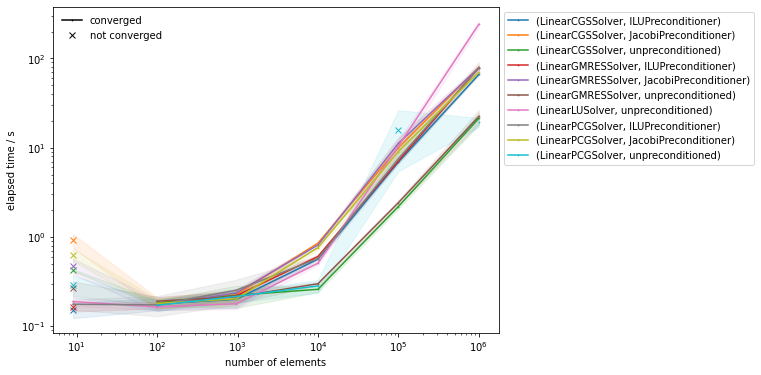

In [455]:
trilinos = nucleation_total["package.solver"] == "no-pysparse"
petsc = nucleation_total["package.solver"] == "petsc"
scipy = nucleation_total["package.solver"] == "scipy"
pysparse = nucleation_total["package.solver"] == "pysparse"
pyamgx = nucleation_total["package.solver"] == "pyamgx"

plot_all(nucleation_total[scipy], color_by_suite=False,
         by=["solver_class", "preconditioner"])
# plot_all(nucleation_total)
# plt.ylim(bottom=1e-1, top=1e3)
# plt.xlim(left=1e1, right=1e6)

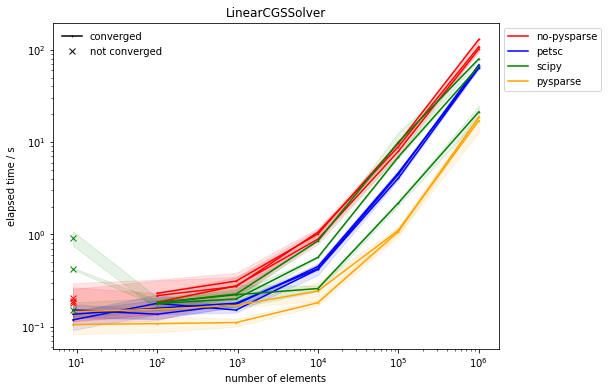

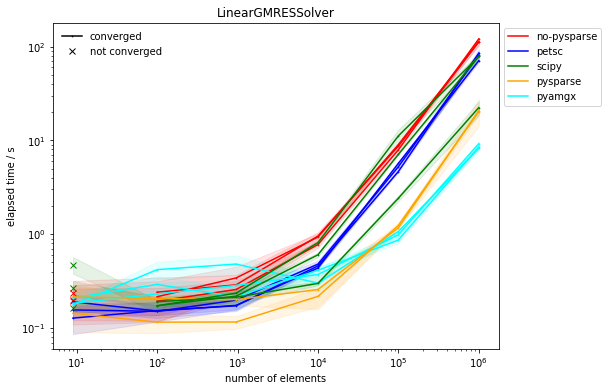

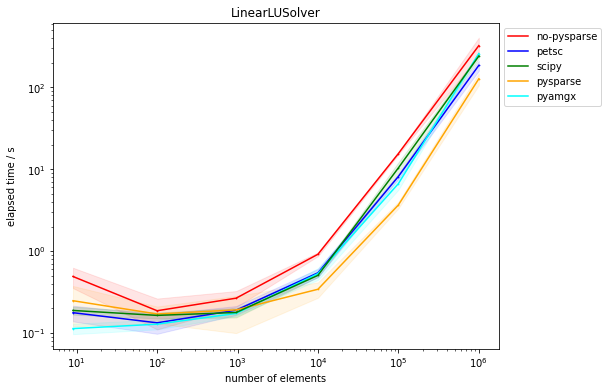

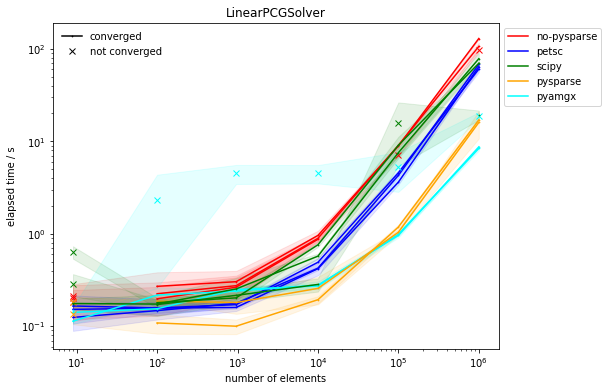

In [447]:
plot_by_solver(nucleation_total)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1875063161.py:63: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


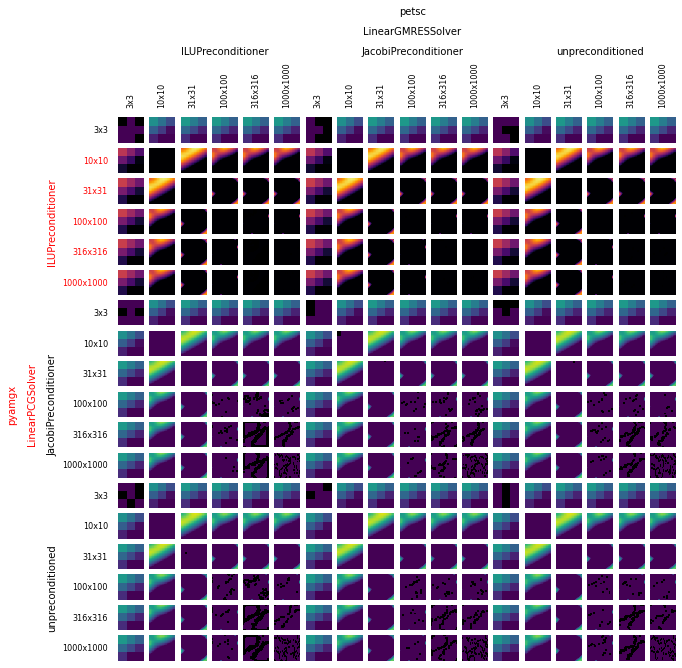

In [742]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", diff_fn=extract_and_diff, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


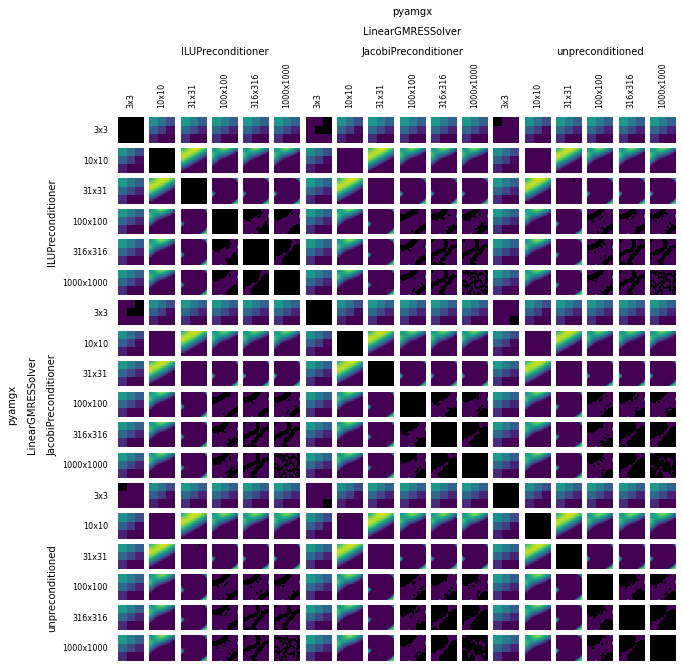

In [756]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", diff_fn=extract_and_diff, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


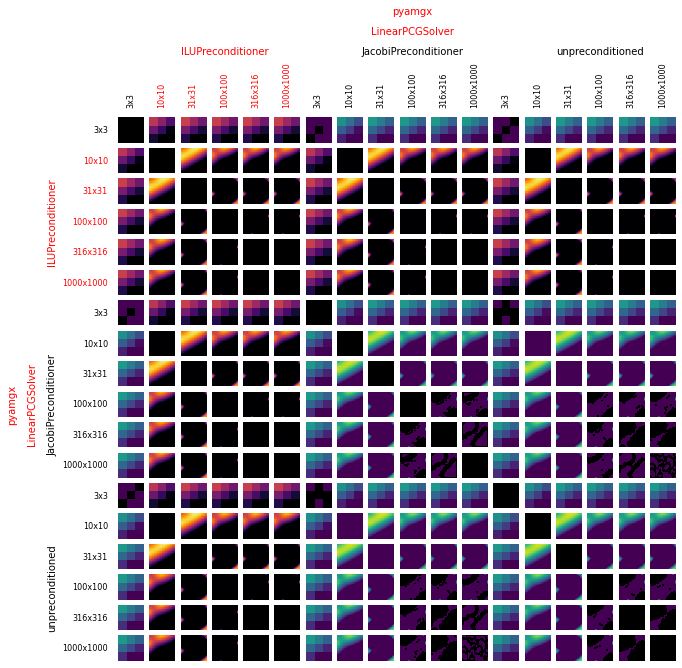

In [757]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", diff_fn=extract_and_diff, key="phi")

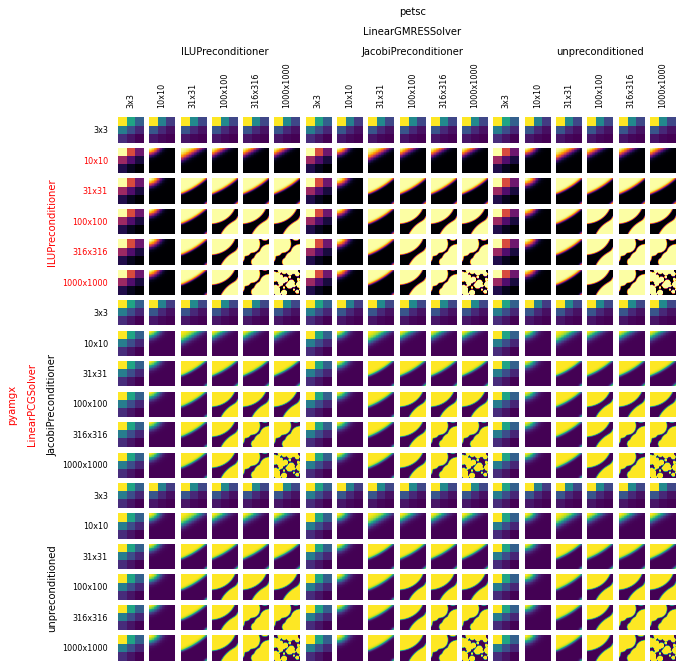

In [748]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", diff_fn=value1, key="phi", logvalue=False)

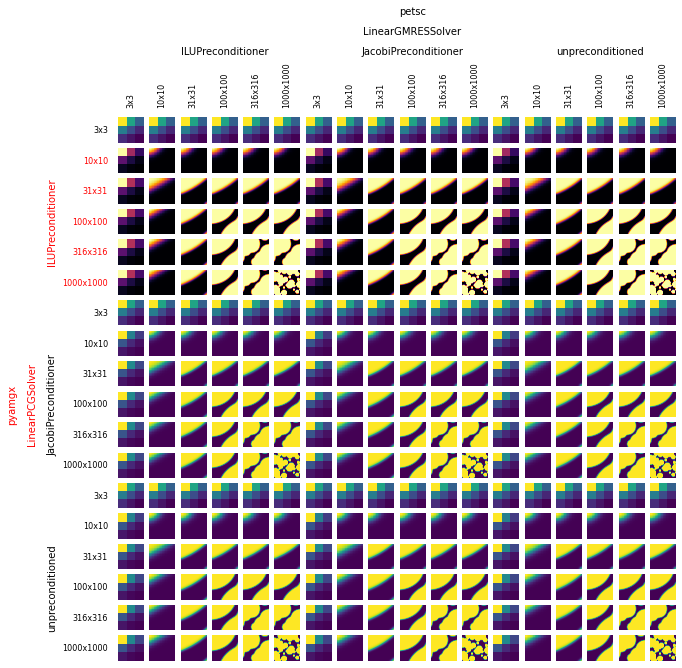

In [749]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", diff_fn=value2, key="phi", logvalue=False)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


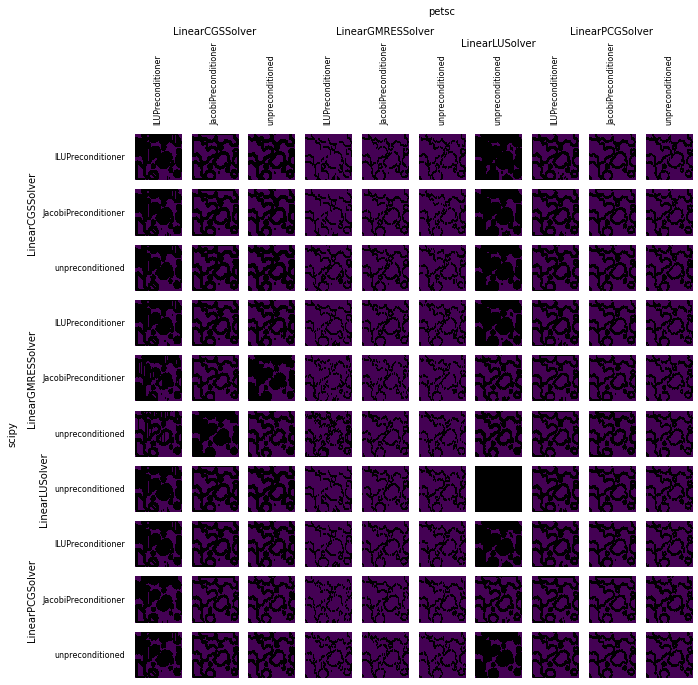

In [752]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "scipy")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  datafile="t=301.0.npz", diff_fn=extract_and_diff, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1420086669.py:64: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


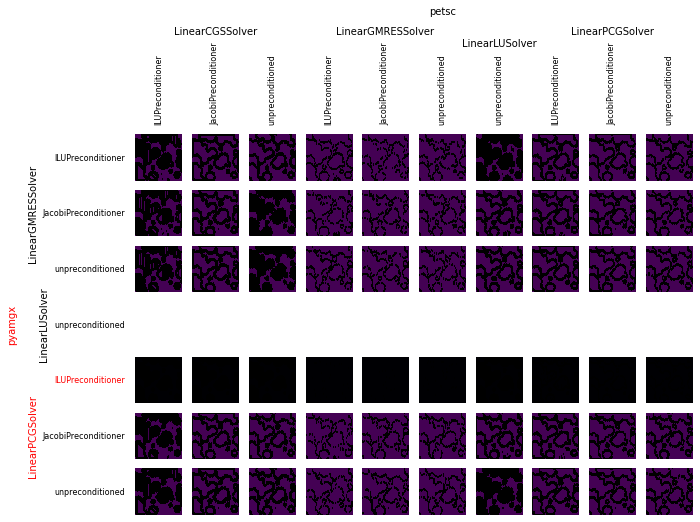

In [753]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  diff_fn=extract_and_diff,
                  datafile="t=301.0.npz", key="phi")

## Compare solutions

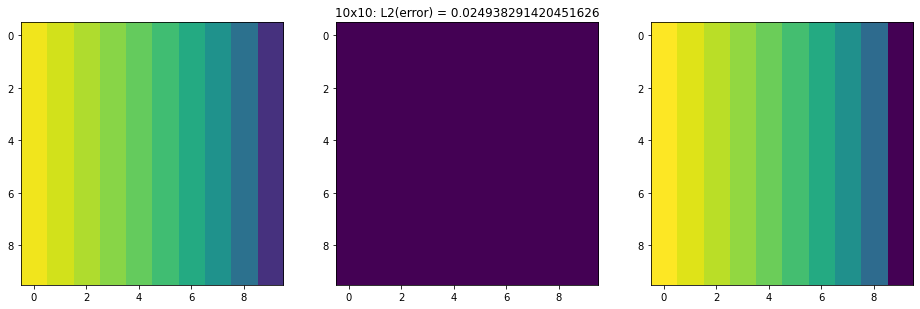

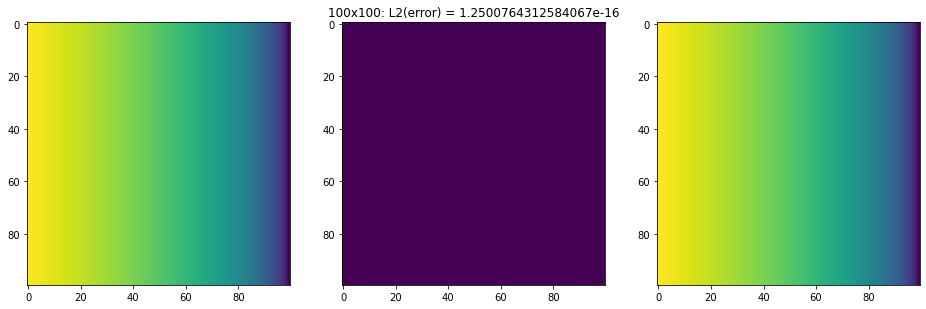

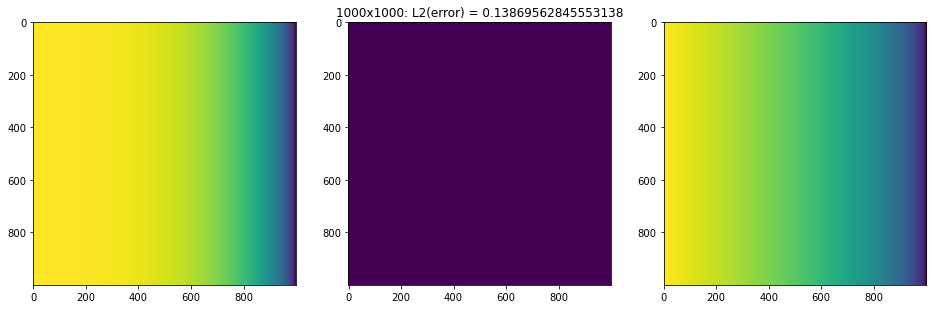

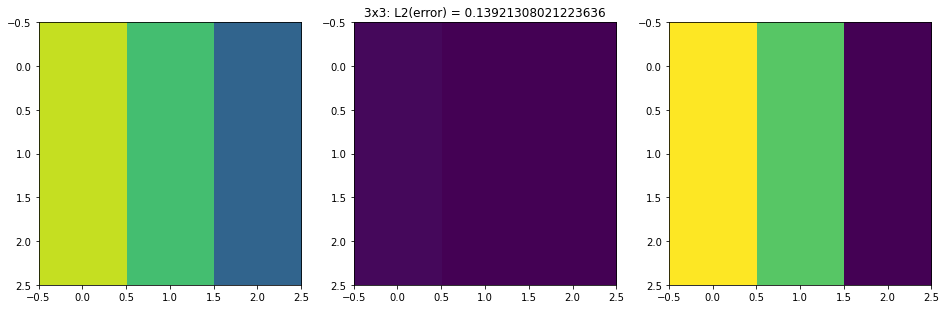

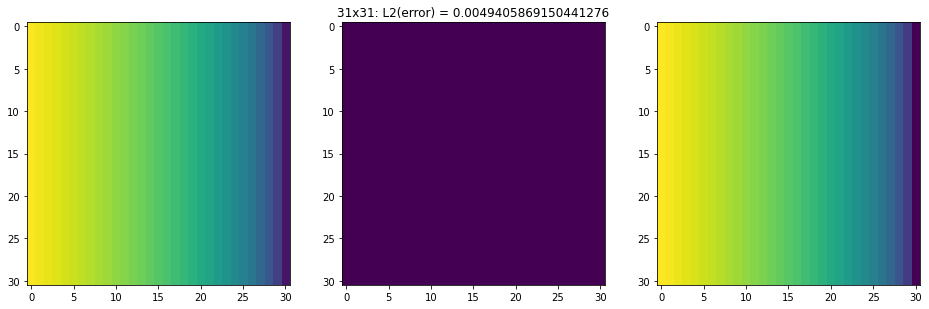

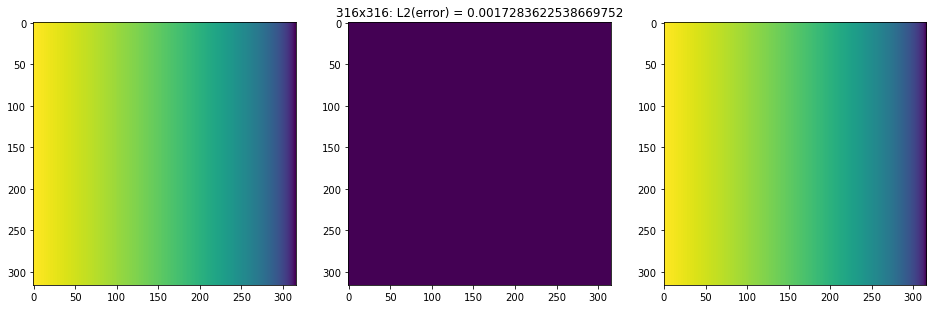

In [57]:
qreference = "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
datasets = glob.glob("gpu/pyamgx/LinearGMRESSolver/*/solution.tsv")
datasets.sort()
for dataset in datasets:
    compare(dataset, reference)

In [125]:
for path in glob.glob("linux/petsc/LinearPCGSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [354]:
for path in glob.glob("linux/petsc/LinearGMRESSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [355]:
for path in glob.glob("linux/petsc/LinearCGSSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [356]:
for path in glob.glob("linux/petsc/LinearLUSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [357]:
for path in glob.glob("linux/scipy/*/*/*/solution.tsv"):
    tsv2npz(path)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


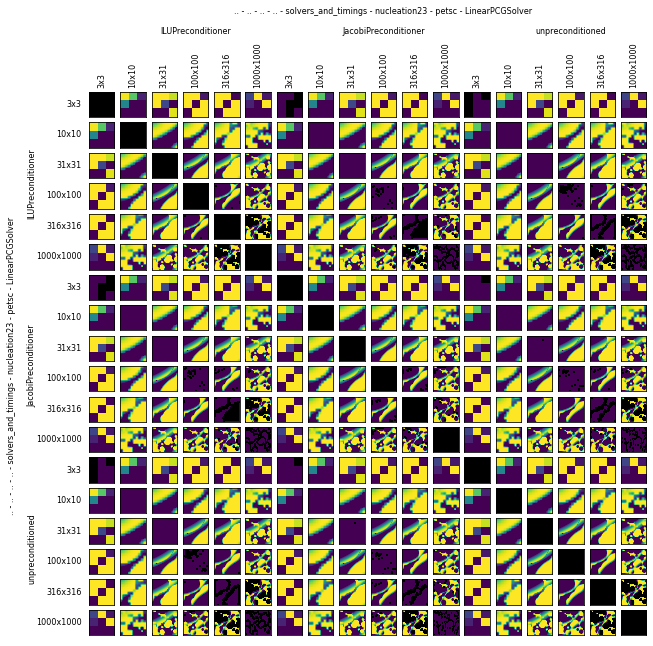

In [50]:
plot_error_matrix("../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  "../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  nucleation, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


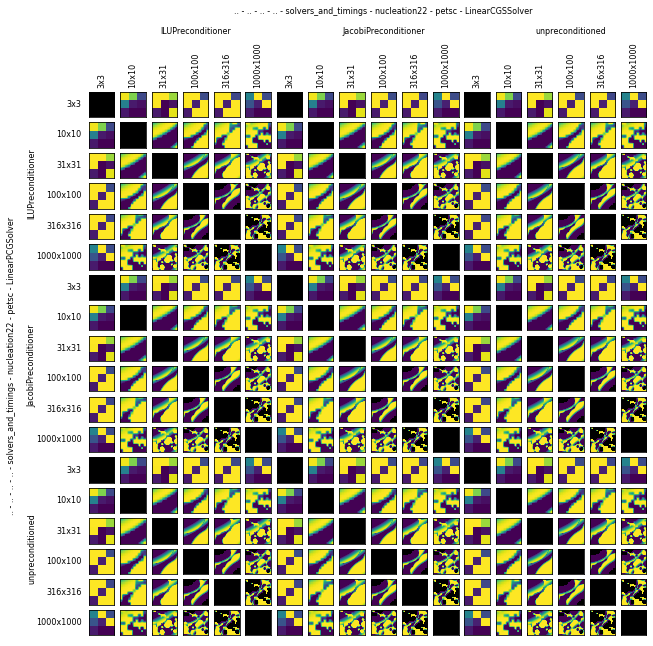

In [46]:
plot_error_matrix("../../../../solvers_and_timings/nucleation22/petsc/LinearCGSSolver/*/*/t=300.0.npz",
                  "../../../../solvers_and_timings/nucleation22/petsc/LinearPCGSolver/*/*/t=300.0.npz",
                  nucleation, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


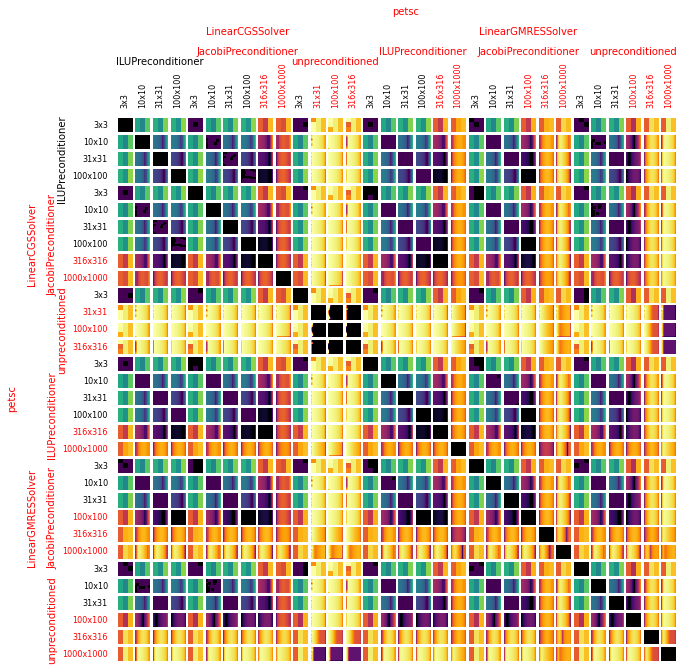

In [787]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  diff_fn=scale_and_diff,
                  datafile="solution.npz", key="value")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


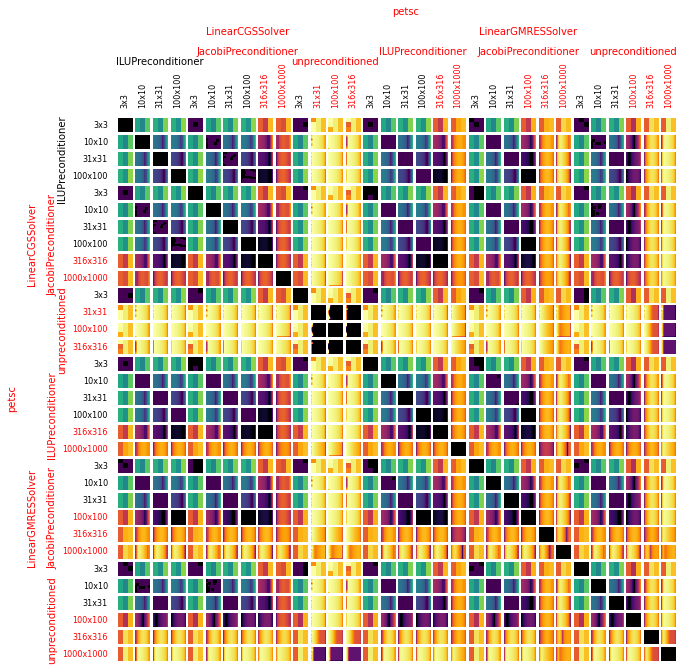

In [787]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  diff_fn=scale_and_diff,
                  datafile="solution.npz", key="value")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


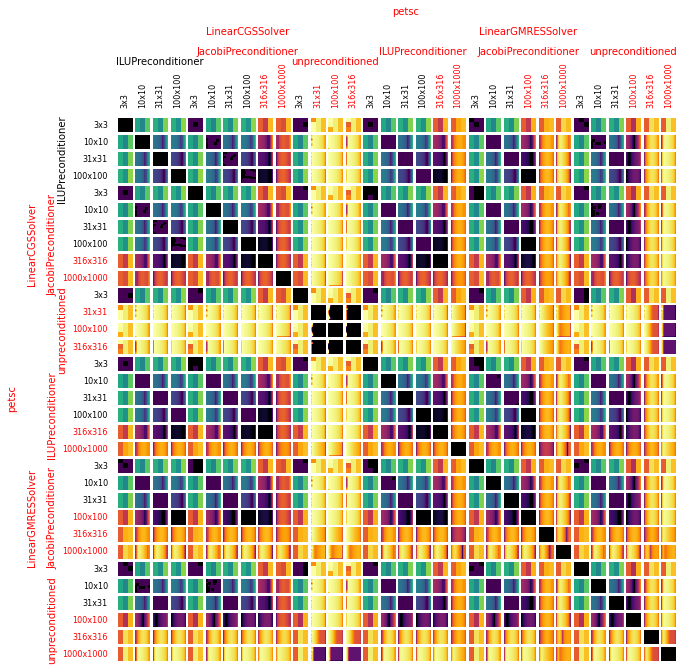

In [787]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  diff_fn=scale_and_diff,
                  datafile="solution.npz", key="value")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


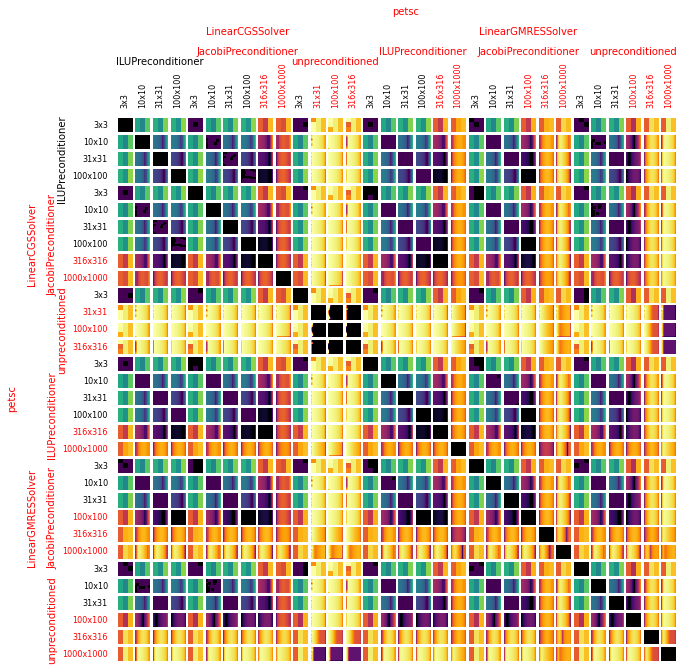

In [787]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  diff_fn=scale_and_diff,
                  datafile="solution.npz", key="value")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2043696119.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


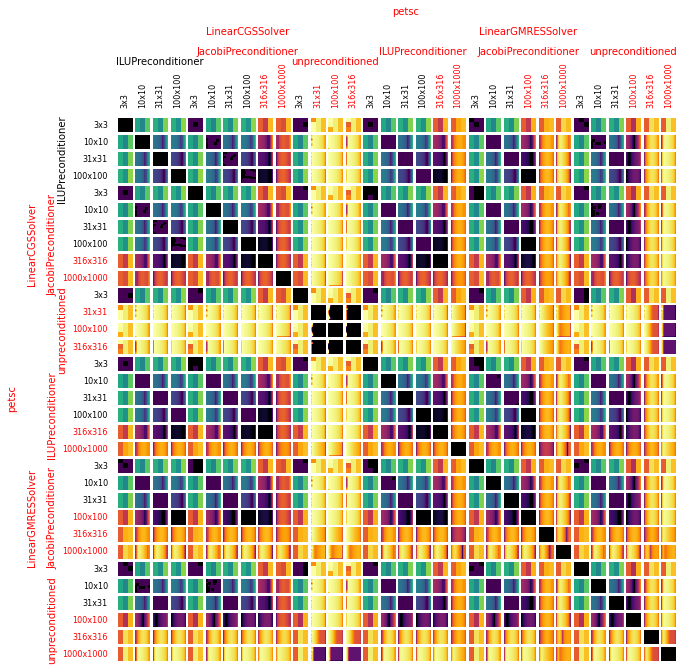

In [787]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearCGSSolver", "LinearGMRESSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  diff_fn=scale_and_diff,
                  datafile="solution.npz", key="value")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


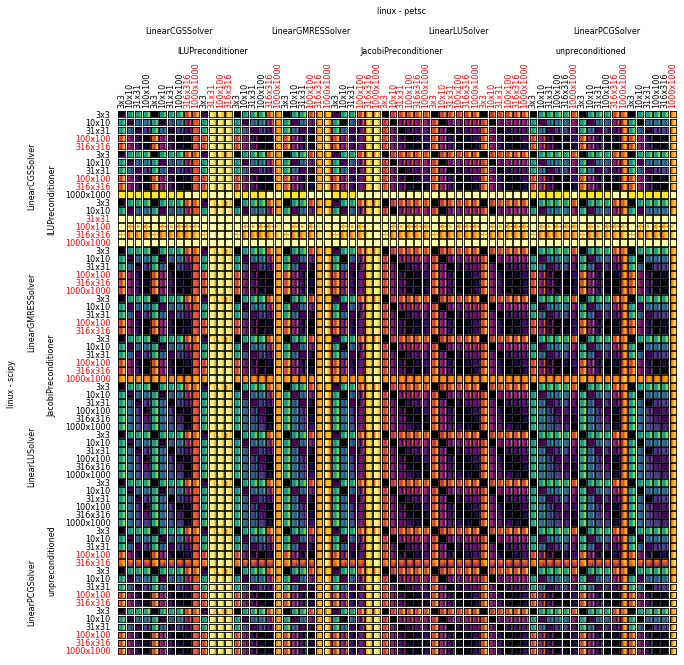

In [361]:
plot_error_matrix("linux/petsc/*/*/*/solution.npz",
                  "linux/scipy/*/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


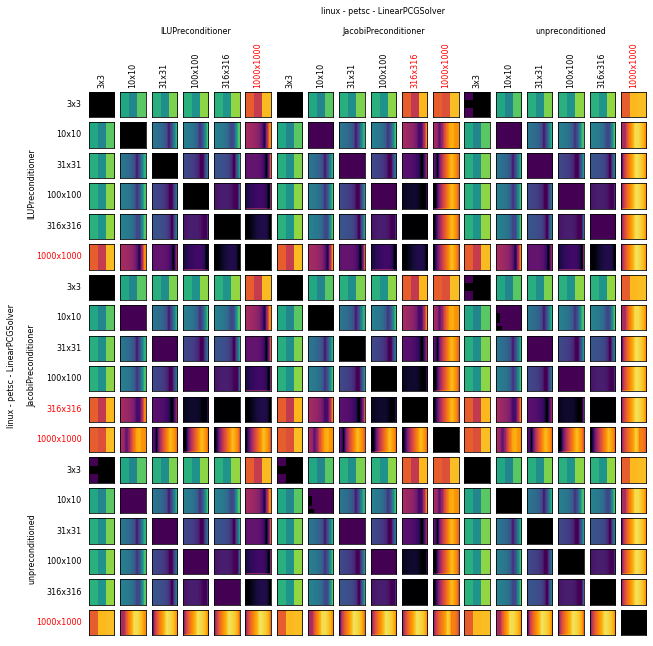

In [353]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  linux)